## Men-Women Detection using Transfer Learning & Data Augmentation

dataset: https://www.kaggle.com/datasets/saadpd/menwomen-classification

In [1]:
import os
import shutil, pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers

## 1- Dataset Preparation

### 1-1. Download Dataset from Kaggle

In [2]:
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d saadpd/menwomen-classification

Dataset URL: https://www.kaggle.com/datasets/saadpd/menwomen-classification
License(s): copyright-authors
 96% 771M/806M [00:06<00:00, 77.9MB/s]
100% 806M/806M [00:07<00:00, 120MB/s] 


In [5]:
!unzip -qq menwomen-classification.zip

### 1-2. Dataset Evaluation

In [ ]:
num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))
num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print(f'Train: men: {num_men_train} | women: {num_women_train}')
print(f'Test: men: {num_men_test} | women: {num_women_test}')

Train: men: 1000 | women: 1912
Test: men: 418 | women: 915


### 1-3. Prepare Data Directories

In [6]:
new_base_dir = pathlib.Path("men_vs_women_small")

def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ("men", "women"):
        dir = new_base_dir / subset_name / category
        if not os.path.exists(dir):
            os.makedirs(dir)
        files = os.listdir(os.path.join(base_dir, category))
        fnames = [files[i] for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=os.path.join(base_dir, category, fname),
            dst=os.path.join(dir, fname))

In [7]:
make_subset("traindata/traindata", "validation", start_index=0, end_index=200)
make_subset("traindata/traindata", "train", start_index=200, end_index=999)
make_subset("testdata/testdata", "test", start_index=0, end_index=400)

In [ ]:
##!zip -qq -r men_vs_women_small.zip men_vs_women_small

### 1-4. Load Dataset

In [8]:
print('Train loader:')
train_dataset = image_dataset_from_directory(
    'men_vs_women_small/train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
)

print('Validation loader:')
validation_dataset = image_dataset_from_directory(
    'men_vs_women_small/validation',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
)

print('Test loader:')
test_dataset = image_dataset_from_directory(
    'men_vs_women_small/test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
)

Train loader:
Found 1598 files belonging to 2 classes.
Validation loader:
Found 400 files belonging to 2 classes.
Test loader:
Found 800 files belonging to 2 classes.


data batch shape: (32, 180, 180, 3)
label batch shape: (32, 1)


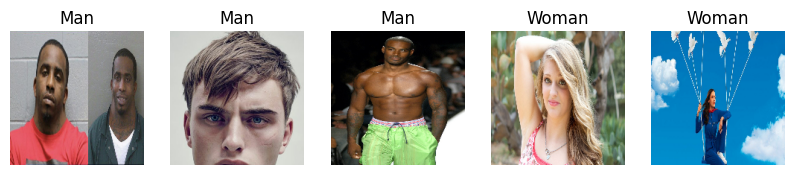

In [9]:
for data_batch, label_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('label batch shape:', label_batch.shape)

    # Show five random examples of the loaded batch
    fig, axes = plt.subplots(1, 5, figsize=(10,3))
    for i, ax in enumerate(axes):
        ax.imshow(data_batch[i].numpy().astype('uint8'))
        ax.set_axis_off()
        ax.set_title('Man' if label_batch[i].numpy()==0 else 'Woman')
    break

plt.show()

## 2- Model Design

In [10]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
conv_base.trainable = False

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [13]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 3- Model Training

In [14]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_transfer_learning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.8852 - loss: 0.2883 - val_accuracy: 0.8925 - val_loss: 0.3533
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.8702 - loss: 0.2924 - val_accuracy: 0.8900 - val_loss: 0.3352
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.8789 - loss: 0.2866 - val_accuracy: 0.8850 - val_loss: 0.3442
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - accuracy: 0.8930 - loss: 0.2651 - val_accuracy: 0.8875 - val_loss: 0.3515
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - accuracy: 0.8822 - loss: 0.2774 - val_accuracy: 0.8850 - val_loss: 0.3342
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.8817 - loss: 0.2886 - val_accuracy: 0.8925 - val_loss: 0.3554
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.8790 - loss: 0.2728 - val_accuracy: 0.8875 - val_loss: 0.3586
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step - accuracy: 0.8767 - loss: 0.2907 - val_accu

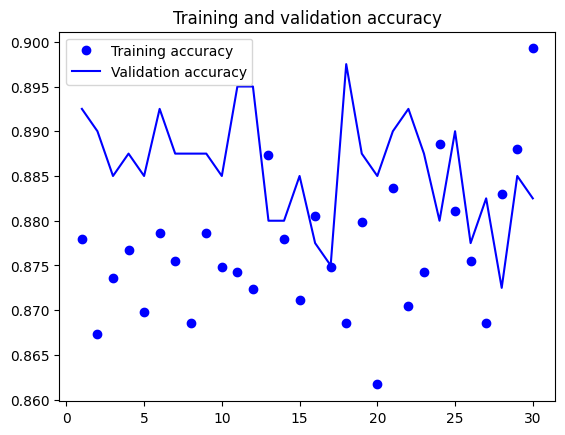

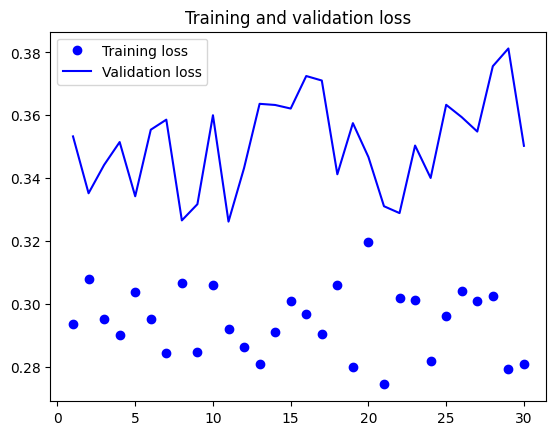

In [27]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [28]:
test_model = keras.models.load_model("convnet_transfer_learning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.8807 - loss: 0.3342
Test accuracy: 0.889


## 4- Fine Tuning

In [30]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [31]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,109,445 (57.64 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 263,172 (1.00 MB)

In [32]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history2 = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - accuracy: 0.8755 - loss: 0.3011 - val_accuracy: 0.8875 - val_loss: 0.3377
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.9071 - loss: 0.2315 - val_accuracy: 0.8950 - val_loss: 0.3198
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 244ms/step - accuracy: 0.9329 - loss: 0.1675 - val_accuracy: 0.9000 - val_loss: 0.3227
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 237ms/step - accuracy: 0.9283 - loss: 0.1840 - val_accuracy: 0.9000 - val_loss: 0.3744
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.9439 - loss: 0.1471 - val_accuracy: 0.8975 - val_loss: 0.3842
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.9418 - loss: 0.1409 - val_accuracy: 0.8950 - val_loss: 0.3408
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.9572 - loss: 0.1119 - val_accuracy: 0.9075 - val_loss: 0.3539
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - accuracy: 0.9557 - loss: 0.1101 - val_accu

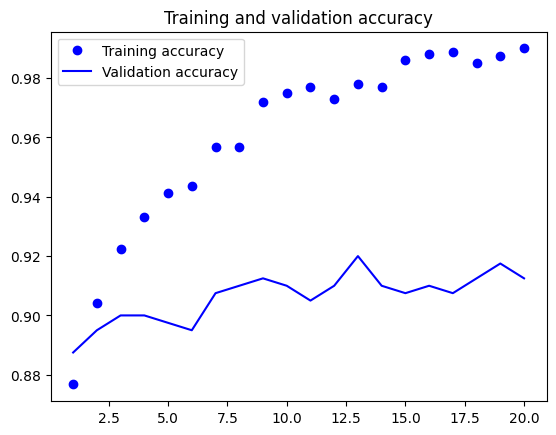

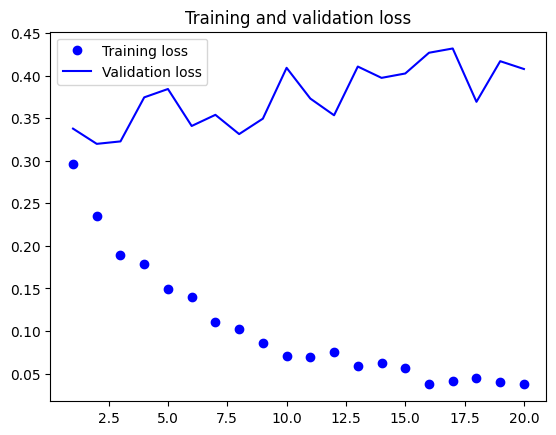

In [34]:
accuracy = history2.history["accuracy"]
val_accuracy = history2.history["val_accuracy"]
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [35]:

test_model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.9029 - loss: 0.2920
Test accuracy: 0.914
